# Define imports

In [1]:
#!pip install opencv-python
import os
import cv2
import os
import glob
import numpy as np
from Regressor_Model_Controller import Regressor_Model_Controller
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torch
import torchvision.transforms as transforms
import math
import random


torch.set_default_tensor_type(torch.FloatTensor)

# Define constants

In [13]:

DIPALI_HOME = './DLWG/DataSet/*.jpg'
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
REGRESSOR_SAVED_MODEL_PATH= './Model/Regressor/Regressor.pth'
REGRESSOR_EPOCH = 75
REGRESSOR_LOSS_PLOT_PATH = "./Plots/Regressor/Regressor_Loss_plot"
REGRESSOR_LR = 0.0001
REGRESSOR_WEIGHT_DECAY = 1e-5
REGRESSOR_IN_CHANNEL = 1
REGRESSOR_HIDDEN_CHANNEL = 3
REGRESSOR_OUT_DIMS = 2
REGRESSOR_BATCH_SIZE_CPU = 32
REGRESSOR_BATCH_SIZE_CUDA = 8
REGRESSOR_TEST_SPLIT=0.1

os.makedirs("./Model/Regressor/", exist_ok=True)
os.makedirs("./Plots/Regressor/",exist_ok=True)

# Use GPU if available

In [3]:
def get_device():
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        is_cuda_present = True if torch.cuda.is_available() else False
        num_workers = 8 if is_cuda_present else 0

        return device, is_cuda_present, num_workers

# Load image data from folder old

In [4]:
def image_modification(file,nimages):
    img = cv2.imread(file)

    #Resize to respect the input_shape
    inp = cv2.resize(img, (IMAGE_WIDTH , IMAGE_HEIGHT))

    #Convert img to RGB
    rgb = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
    
    return img
    

def read_images_to_tensor(filepath):
    
    files = glob.glob(filepath)
    nimages = len(files)
    data = []
    #print(files)
    for f1 in files:
        #cv2.imshow('image',img)
        data.append(image_modification(f1,nimages))
    return torch.tensor(data)


data_tensor = read_images_to_tensor(DIPALI_HOME)

In [5]:
data_set_dir = './DataSet'
image_paths = os.listdir(data_set_dir)
image_paths = [image_path for image_path in image_paths if image_path.endswith('.jpg')]
random.shuffle(image_paths)
image_data = [cv2.imread(os.path.join(data_set_dir, image_path)) for image_path in image_paths]

transformed_image_data = []

transform_color = transforms.Compose([transforms.ToTensor()])

for image_path in image_paths:
    image = cv2.imread(os.path.join(data_set_dir, image_path))
    imageLAB = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #print(imageLAB.shape)
    image_lab = transform_color(image)
    image_gray = image_lab[0:1,:,:]

    image_a = image_lab[1:2, :, :]
    #print(image_a.shape)

    image_b = image_lab[2:3, :, :]
    #print(image_b.shape)
    #print(image_b)
    #plt.imshow(image_b)
    #plt.show()
    

    transformed_image_data.append((image_gray, image_a, image_b))


# load augmented image data

In [19]:
train_data_set_dir = './TrainSet'
test_data_set_dir = './TestSet'

train_image_paths = os.listdir(train_data_set_dir)
test_image_paths = os.listdir(test_data_set_dir)

train_image_paths = [image_path for image_path in train_image_paths if image_path.endswith('.jpg')]
test_image_paths = [image_path for image_path in test_image_paths if image_path.endswith('.jpg')]

random.shuffle(train_image_paths)
random.shuffle(test_image_paths)

train_image_data = [cv2.imread(os.path.join(train_data_set_dir, image_path)) for image_path in train_image_paths]
test_image_data = [cv2.imread(os.path.join(test_data_set_dir, image_path)) for image_path in test_image_paths]


# Images to L* a* b* color space convertion

In [41]:
# LAB color space
train_image_data = [cv2.cvtColor(image, cv2.COLOR_BGR2LAB) for image in train_image_data]
test_image_data = [cv2.cvtColor(image, cv2.COLOR_BGR2LAB) for image in test_image_data]


### Display L* a* b images

143


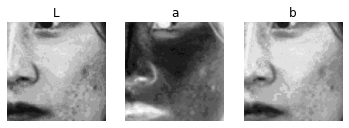

In [46]:
def showImageLab(image_Lab):
    #image_bgr = cv2.imread(image_file)
    #image_Lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)

    L = image_Lab[:, :, 0]
    a = image_Lab[:, :, 1]
    b = image_Lab[:, :, 2]
    print(np.max(a))
    plt.subplot(1, 3, 1)
    plt.title('L')
    plt.gray()
    plt.imshow(L)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('a')
    plt.gray()
    plt.imshow(a)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('b')
    plt.gray()
    plt.imshow(b)
    plt.axis('off')

    plt.show() 
    
#print(test_image_data[:5])

showImageLab(train_image_data[5])


In [8]:
# Convert images to tensors
transform_color = transforms.Compose([transforms.ToTensor()])

transformed_train_image_data = []
transformed_test_image_data = []

for image in train_image_data:
    # train image to tensor
    image_lab = transform_color(image)
    image_gray = image_lab[0:1,:,:]
    image_a = image_lab[1:2, :, :]
    print()
    image_b = image_lab[2:3, :, :]
    transformed_train_image_data.append((image_gray, image_a, image_b))

for image in test_image_data:
    # test image to tensor
    image_lab = transform_color(image)
    image_gray = image_lab[0:1,:,:]
    image_a = image_lab[1:2, :, :]
    image_b = image_lab[2:3, :, :]
    transformed_test_image_data.append((image_gray, image_a, image_b))


In [33]:
#a_list = np.array(transformed_test_image_data)
np.amax(train_image_data,axis=0)
#print(transformed_test_image_data[:1])

array([[[157, 167, 132],
        [157, 167, 133],
        [157, 167, 132],
        ...,
        [165, 169, 132],
        [166, 166, 132],
        [166, 166, 133]],

       [[157, 167, 132],
        [156, 168, 133],
        [157, 168, 132],
        ...,
        [165, 167, 132],
        [166, 167, 132],
        [165, 166, 133]],

       [[157, 167, 132],
        [156, 168, 133],
        [156, 167, 132],
        ...,
        [165, 166, 132],
        [166, 169, 132],
        [166, 165, 133]],

       ...,

       [[166, 167, 132],
        [166, 169, 133],
        [165, 167, 132],
        ...,
        [165, 167, 132],
        [166, 169, 133],
        [166, 168, 132]],

       [[166, 167, 133],
        [166, 168, 133],
        [165, 168, 132],
        ...,
        [165, 168, 132],
        [166, 168, 134],
        [165, 168, 133]],

       [[166, 167, 132],
        [166, 167, 133],
        [165, 167, 132],
        ...,
        [165, 169, 132],
        [166, 168, 133],
        [166, 168, 133]]

# Train/Test batch data loading

In [10]:
train_image_data = []
test_image_data = []

batch_size = REGRESSOR_BATCH_SIZE_CUDA
# include both color and gray images
trainloader = torch.utils.data.DataLoader(transformed_train_image_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(transformed_test_image_data, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

# Train the Regressor

In [14]:
def train_regressor(augmented_dataset_batch, device):
        regressor_train_arguments = {
            "data_loader": augmented_dataset_batch,
            "saved_model_path": REGRESSOR_SAVED_MODEL_PATH,
            "epochs": REGRESSOR_EPOCH,
            "learning_rate": REGRESSOR_LR,
            "weight_decay": REGRESSOR_WEIGHT_DECAY,
            "in_channel": REGRESSOR_IN_CHANNEL,
            "hidden_channel": REGRESSOR_HIDDEN_CHANNEL,
            "out_dims": REGRESSOR_OUT_DIMS,
            "loss_plot_path": REGRESSOR_LOSS_PLOT_PATH
        }

        regressor_manager = Regressor_Model_Controller()
        regressor_manager.train(regressor_train_arguments, device)

def test_regressor(augmented_dataset_batch, device):
        regressor_arguments = {
            "data_loader": augmented_dataset_batch,
            "saved_model_path": REGRESSOR_SAVED_MODEL_PATH,
            "in_channel": REGRESSOR_IN_CHANNEL,
            "hidden_channel": REGRESSOR_HIDDEN_CHANNEL,
            "out_dims": REGRESSOR_OUT_DIMS,
            "loss_plot_path": REGRESSOR_LOSS_PLOT_PATH
        }

        regressor_manager = Regressor_Model_Controller()
        regressor_manager.test(regressor_arguments, device)

In [15]:
device, is_cuda_present, num_workers = get_device()
train_regressor(trainloader,device)

..Regressor training started..
1 3 2
epoch: 0, loss: 0.4667457555915462
epoch: 1, loss: 0.07094222962041385
epoch: 2, loss: 0.05600653632427566
epoch: 3, loss: 0.04267832035111496
epoch: 4, loss: 0.03540792181593133
epoch: 5, loss: 0.03365237770412932
epoch: 6, loss: 0.030748097007744946
epoch: 7, loss: 0.026190483546088217
epoch: 8, loss: 0.024128628305334132
epoch: 9, loss: 0.027687769746989943
epoch: 10, loss: 0.02041702410497237
epoch: 11, loss: 0.023894692574685905
epoch: 12, loss: 0.021800526172228274
epoch: 13, loss: 0.02046769440130447
epoch: 14, loss: 0.016864684355823556
epoch: 15, loss: 0.016171250863408204
epoch: 16, loss: 0.01536295417099609
epoch: 17, loss: 0.014443503749134834
epoch: 18, loss: 0.015006339999672491
epoch: 19, loss: 0.01409627751854714
epoch: 20, loss: 0.019396843083086424
epoch: 21, loss: 0.013932631833085907
epoch: 22, loss: 0.015390803600894287
epoch: 23, loss: 0.015684048194088973
epoch: 24, loss: 0.013192057673222735
epoch: 25, loss: 0.012926341560159

<Figure size 432x288 with 0 Axes>

In [16]:
test_regressor(testloader,device)

..Regressor testing started..
1 3 2
MSE: 0.0001495999337445634
Image_num || Mean a || Mean b
Image: 1 mean_a: 9.511793971061707 mean_b:10.02985817193985
Image: 2 mean_a: 18.393209397792816 mean_b:11.500607252120972
